# Kaggle : Titanic competition

## Introduction

This is the work I did for the famous Kaggle competition **Titanic**.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The notebook explains my work, the choices I did and the results I got.

In [1]:
# use of pandas for data processing
import pandas as pd
import math
import numpy as np
# SCIKIT LEARN
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
# KERAS
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import matplotlib.pyplot as plt

## Data processing 

First, I stored the data into pandas dataframes and applied some transformations on data.

In [2]:
# file paths
training_file = "../data/train.csv"
submission_file = "../data/test.csv"

In [3]:
# creation of a dataframe for each file
training_df = pd.read_csv(training_file)
submission_df = pd.read_csv(submission_file)

In [4]:
# training data overview 
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# list of features uses for training
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
#not used : ticket and cabin

In [6]:
# drop all lines with at least one Nan value
# training_df = training_df.dropna(axis=0, how='any',subset = features)

# replace all NaN values with -1 (different class)
for feature in features:
    training_df[feature] = training_df[feature].fillna(-1)
    submission_df[feature] = submission_df[feature].fillna(-1)

In [7]:
# training data overview
submission_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### What is inside training data ?

I splited the data into a training set (80% of data) and a test set (20% of data). I trained the models on training set and tested models accuracies on test set. 

In [8]:
# split of dataframe into the test and training dataframe
training_df, test_df = train_test_split(training_df, test_size = 0.3)

In [9]:
print("Training set : ")
# number of rows per class
tr_nb = training_df['Survived'].value_counts()
print("Total row : ",tr_nb.sum(), " ---  Survivors : ", tr_nb[0] , " --- Death people", tr_nb[1])
print("Proportion of survivors : ", int(100*tr_nb[1]/tr_nb.sum()),'%')

print("\nTest set : ")
# number of rows per class
ts_nb = test_df['Survived'].value_counts()
print("Total row : ",ts_nb.sum(), " ---  Survivors : ", ts_nb[0] , " --- Death people", ts_nb[1])
print("Proportion of survivors : ", int(100*ts_nb[1]/ts_nb.sum()),'%')

Training set : 
Total row :  623  ---  Survivors :  398  --- Death people 225
Proportion of survivors :  36 %

Test set : 
Total row :  268  ---  Survivors :  151  --- Death people 117
Proportion of survivors :  43 %


The training dataset consists in 569 passengers, 62% of whom died and 38% survived.

The test dataset consists in 143 passengers, 53% of whom died and 47% survived.

The training dataset is **not perfectly balanced**, that is something we should take into account in the next part.

### Rebalancing training data something

The goal here is to achieve 50% of survival and 50% of dissapearence in the training set in order to not introduce bias into our models.  

In [10]:
REBALANCED = False
if REBALANCED :
    # Re - balancing training and test dataframe dataframe
    training_df = pd.concat([training_df.query("Survived == 0")[:tr_nb[1]], training_df.query("Survived == 1")], ignore_index=True)

    test_df = pd.concat([test_df, training_df.query("Survived == 0")[tr_nb[1]:]], ignore_index=True)
    ts_nb = test_df['Survived'].value_counts()
    test_df = pd.concat([test_df.query("Survived == 0")[:ts_nb[1]], test_df.query("Survived == 1")], ignore_index=True)

    # shuffle dataframe
    training_df = training_df.sample(frac = 1).reset_index(drop=True)
    test_df = test_df.sample(frac = 1).reset_index(drop=True)

In [11]:
if REBALANCED :
    print("Training set : ")
    # number of rows per class
    tr_nb = training_df['Survived'].value_counts()
    print("Total row : ",tr_nb.sum(), " ---  Survivors : ", tr_nb[0] , " --- Death people", tr_nb[1])
    print("Proportion of survivors : ", int(100*tr_nb[1]/tr_nb.sum()),'%')

    print("\nTest set : ")
    # number of rows per class
    ts_nb = test_df['Survived'].value_counts()
    print("Total row : ",ts_nb.sum(), " ---  Survivors : ", ts_nb[0] , " --- Death people", ts_nb[1])
    print("Proportion of survivors : ", int(100*ts_nb[1]/ts_nb.sum()),'%')

Now our training set is perfectly balanced with 50% of each attribute.

### Strategy

The goal here is to learn from the training dataset, if a given passenger would survived the titanic shipwreck.

To do so, we have a few information per passenger : 
- the passenger id (PassengerId)
- whether he survived or not (Survived)
- the ticket class (Pclass)
- his name (Name)
- his sex (Sex)
- his age (Age)
- the number of siblings/spouses aboard the Titanic (SibSp)
- the number of parents/children abroad the Titanic (Parch)
- the ticket number (Ticket)
- the passenger fare (Fare)
- the cabin number (Cabin)
- the port of embarkation (Embarked)

Those information include a number of interesting features (inputs) to predict the output : whether a passenger survive or not.

This is a **classification problem**, given a passenger, we would like to predict 1 if he survived and 0 otherwise. 

Different machine learning can be used in order predict that. 
For this particular one, I will try several approaches, **Sequential Neural Network**, **Logistic Regression**, **SVM**, **Tree classifiers** and compare the results.

## 1st approach : Sequential Neural Network

### Structure of the Neural Network :

- **the input layor** consists of the features given in the training dataset and explained above
- **two headen layers**
- **the output layer** consists in one neuron, activated by a **sigmoid** function. With a threshold of 0.5, this neuron gives the prediction of the death of a given passenger.

The NN is trained with **keras** and tested on the test dataset.


### The input layer

The input layer is composed of 7 features, the relevant passenger information, i-e the class, the sex, the age, the family information, the fare and the embarked port. The other features (id, name, the ticket and cabin numbers) seems not so relevant to decide whether a passenger is more lucky to survive than an other one.

The input layer is a 7-element normalised vector.  

In [12]:
# Preprocessing of dataframe : here I changed some dataframe columns from qualitative data into quantitative data

# modification of the Sex column for both training and test set
training_df['Sex'] = training_df['Sex'].replace(["male"],0.0)
training_df['Sex'] = training_df['Sex'].replace(["female"],1.0)
test_df['Sex'] = test_df['Sex'].replace(["male"],0.0)
test_df['Sex'] = test_df['Sex'].replace(["female"],1.0)

# modification  of the Sex column for both training and test set
training_df['Embarked'] = training_df['Embarked'].replace(["C"],0.0)
training_df['Embarked'] = training_df['Embarked'].replace(["Q"],0.5)
training_df['Embarked'] = training_df['Embarked'].replace(["S"],1.0)
test_df['Embarked'] = test_df['Embarked'].replace(["C"],0.0)
test_df['Embarked'] = test_df['Embarked'].replace(["Q"],0.5)
test_df['Embarked'] = test_df['Embarked'].replace(["S"],1.0)


training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",1.0,9.0,2,2,W./C. 6608,34.3750,NaN,1.0
562,563,0,2,"Norman, Mr. Robert Douglas",0.0,28.0,0,0,218629,13.5000,NaN,1.0
851,852,0,3,"Svensson, Mr. Johan",0.0,74.0,0,0,347060,7.7750,NaN,1.0
716,717,1,1,"Endres, Miss. Caroline Louise",1.0,38.0,0,0,PC 17757,227.5250,C45,0.0
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",1.0,29.0,0,2,2650,15.2458,NaN,0.0


In [13]:
# replace nan value with average value
# avg_values_tra = training_df[colufeaturesmns].mean(axis=0, skipna=True)
# for column in features:
#     training_df[column] = training_df[column].replace([np.NAN],avg_values_tra[column])

# avg_values_test = test_df[features].mean(axis=0, skipna=True)
# for column in features:
#     test_df[column] = test_df[column].replace([np.NAN],avg_values_tra[column])

In [14]:
# normalisation of the training and test dataframes
minmax = preprocessing.MinMaxScaler()

training_array = minmax.fit_transform(training_df[features].values)
test_array = minmax.fit_transform(test_df[features].values)


In [15]:
# input data processing : creation of the input and output layers
input_training_data = training_array
output_training_data = training_df["Survived"].values


In [16]:
# test data processing : creation of the input and output layers
input_test_data = test_array
output_test_data = test_df["Survived"].values

### Neural network training

In [17]:
# definition of our keras model (using sequential neural network)
model = Sequential()
# add a hidden layer with 64 nodes with activation relu
model.add(Dense(64, input_dim=len(features), activation='relu'))
# add a little dropout 
model.add(Dropout(0.2))
# add an other hidden layer with 32 nodes with activation relu
model.add(Dense(32, activation='relu'))
# add a little dropout
model.add(Dropout(0.2))
# add an other hidden layer with 16 nodes with activation relu
model.add(Dense(16, activation='relu'))
# add an other hidden layer with 8 nodes with activation relu
model.add(Dense(8, activation='relu'))
# add the output layer with activation sigmoid
model.add(Dense(1, activation='sigmoid'))



In [18]:
# compiling the model with binary_crossentropy loss, adam optimizer and accuracy metrics 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# displaying the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

In [19]:
# training the model with training data
EPOCHS = 15
BATCH_SIZE = 16
# fiting model
history = model.fit(input_training_data, output_training_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    shuffle=True,
    validation_data = (input_test_data, output_test_data))

ss: 0.5859 - val_accuracy: 0.6940
Epoch 2/15
39/39 [==============================] - 0s 3ms/step - loss: 0.5202 - accuracy: 0.7978 - val_loss: 0.4945 - val_accuracy: 0.7649
Epoch 3/15
39/39 [==============================] - 0s 3ms/step - loss: 0.4869 - accuracy: 0.8026 - val_loss: 0.4944 - val_accuracy: 0.7649
Epoch 4/15
39/39 [==============================] - 0s 3ms/step - loss: 0.4850 - accuracy: 0.7961 - val_loss: 0.4874 - val_accuracy: 0.7761
Epoch 5/15
39/39 [==============================] - 0s 3ms/step - loss: 0.4522 - accuracy: 0.8042 - val_loss: 0.5079 - val_accuracy: 0.7799
Epoch 6/15
39/39 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.8202 - val_loss: 0.4811 - val_accuracy: 0.7873
Epoch 7/15
39/39 [==============================] - 0s 3ms/step - loss: 0.4416 - accuracy: 0.8122 - val_loss: 0.4791 - val_accuracy: 0.7799
Epoch 8/15
39/39 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.8266 - val_loss: 0.4775 - val_acc

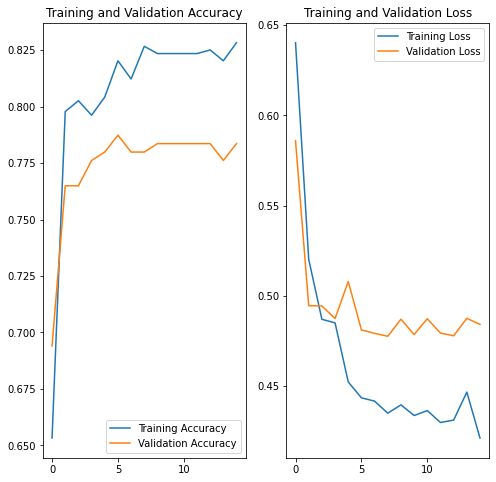

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# evaluation of model accuracy
_ , nn_acc = model.evaluate(input_test_data, output_test_data, batch_size=BATCH_SIZE)
print('Neural Network accuracy : ', nn_acc)

17/17 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.7836
Neural Network accuracy :  0.7835820913314819


The neural netork has been trained with an **accuracy** of **70%**.
Let's build some indicator, **confusion matrix and AUC-ROC** to check this value.

In [22]:
def predict(vec_sentence):
    """
    This function takes a sentence's vector and returns the output of the neural network (rounded to 0 or 1).
    """
    return np.round(model.predict(vec_sentence))

In [23]:
# results of the predictions with trained neural network
pred = [round(elt[0]) for elt in predict(input_test_data)]
nn_confusion_matrix = confusion_matrix(output_test_data, pred)
print("Confusion matrix : \n",nn_confusion_matrix)


Confusion matrix : 
 [[143   8]
 [ 50  67]]


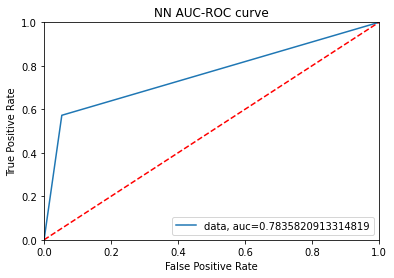

In [24]:
# calculate the false positive rate fpr and true positive tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(output_test_data, pred)

plt.plot(fpr,tpr,label="data, auc="+str(nn_acc))
plt.title('NN AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




## Conclusion du RNN

The results I got are very satisfaying. The accuracy is very high and the network is able to learn from data and predict wheter a Titanic passenger will die or not.

In [25]:
# Submission file building

# submission data processing
submission_df['Sex'] = submission_df['Sex'].replace(["male"],0.0)
submission_df['Sex'] = submission_df['Sex'].replace(["female"],1.0)

submission_df['Embarked'] = submission_df['Embarked'].replace(["C"],0.0)
submission_df['Embarked'] = submission_df['Embarked'].replace(["Q"],0.5)
submission_df['Embarked'] = submission_df['Embarked'].replace(["S"],1.0)

input_submission_data = minmax.fit_transform(submission_df[features].values)


In [26]:
# build the string for the kaggle submission
submission_content = "PassengerId,Survived\n"

pred_submission = [int(elt[0]) for elt in predict(input_submission_data)]

for i in range(submission_df.shape[0]):
    submission_content += (str(submission_df["PassengerId"][i]) + "," + str(int(pred_submission[i])) + "\n")

print(submission_content)


4,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
1047,0
1048,1
1049,0
1050,0
1051,0
1052,1
1053,0
1054,1
1055,0
1056,0
1057,0
1058,0
1059,0
1060,1
1061,0
1062,0
1063,0
1064,0
1065,0
1066,0
1067,1
1068,1
1069,0
1070,1
1071,1
1072,0
1073,0
1074,1
1075,0
1076,1
1077,0
1078,1
1079,0
1080,0
1081,0
1082,0
1083,0
1084,0
1085,0
1086,0
1087,0
1088,0
1089,0
1090,0
1091,1
1092,1
1093,0
1094,0
1095,1
1096,0
1097,0
1098,1
1099,0
1100,1
1101,0
1102,0
1103,0
1104,0
1105,1
1106,0
1107,0
1108,1
1109,0
1110,1
1111,0
1112,1
1113,0
1114,1
1115,0
1116,1
1117,1
1118,0
1119,1
1120,0
1121,0
1122,0
1123,1
1124,0
1125,0
1126,0
1127,0
1128,0
1129,0
1130,1
1131,1
1132,1
1133,1
1134,0
1135,0
1136,0
1137,0
1138,1
1139,0
1140,1
1141,1
1142,1
1143,0
1144,0
1145,0
1146,0
1147,0
1148,0
1149,0
1150,1
1151,0
1152,0
1153,0
1154,1
1155,0
1156,0
1157,0
1158,0
1159,0
1160,1
1161,0
1162,0
1163,0
1164,1
1165,1
1166,0
11

In [27]:
# second submission
with open("./submission2.csv","w") as sub_file:
    sub_file.write(submission_content)

## Logistic Regression


In [28]:
# Training of our logistic regression
clf = LogisticRegression(random_state=0, solver='lbfgs',verbose=4,max_iter=150000, multi_class='ovr').fit(input_training_data, output_training_data)

log_acc = clf.score(input_test_data, output_test_data)

print("Logistic regression training accuracy : \n",log_acc)

# test of the regression
logistic_prediction = clf.predict(input_test_data)

Logistic regression training accuracy : 
 0.7761194029850746
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### Logistic confusion matrix

In [29]:
log_confusion_matrix = confusion_matrix(output_test_data,logistic_prediction)
print("Logistic confusion matrix : \n",log_confusion_matrix)

Logistic confusion matrix : 
 [[133  18]
 [ 42  75]]


### AUC-ROC score and ROC curve

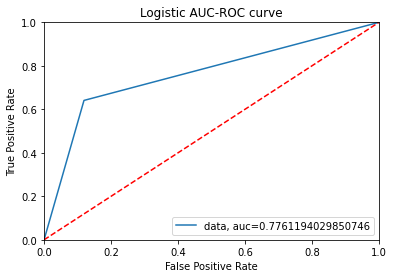

In [30]:
fpr, tpr, threshold = metrics.roc_curve(output_test_data, logistic_prediction)

plt.plot(fpr,tpr,label="data, auc="+str(log_acc))
plt.title('Logistic AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
def predict_logistic(vec_sentence):
    """
    This function takes a sentence's vector and returns the output of the neural network (rounded to 0 or 1).
    """
    if len(vec_sentence) == 1:
        vec_sentence = [vec_sentence]
    return np.round(clf.predict(vec_sentence))

In [32]:
# creation of submission file
submission_content_logistic = "PassengerId,Survived\n"

pred_logistic_submission = [round(elt) for elt in predict_logistic(input_submission_data)]

for i in range(len(submission_df)):
    submission_content_logistic = submission_content_logistic + (str(submission_df["PassengerId"][i]) + "," + str(int(pred_logistic_submission[i])) + "\n")

print(submission_content_logistic[:100])

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
9


### Comparaison beetwen NN and logistic regression appraoch



In [33]:
number_of_differences = 0
for i in range(len(pred_logistic_submission)):
    if pred_logistic_submission[i] != pred_submission[i]:
        number_of_differences += 1
print("Number of differences beetwen both techniques : ",number_of_differences, " / ", len(pred_logistic_submission))
print("Proportion of differences beetwen both techniques : ",np.floor(10000*number_of_differences/len(pred_logistic_submission))/100, "%")

Number of differences beetwen both techniques :  39  /  418
Proportion of differences beetwen both techniques :  9.33 %


## SVM

In [34]:
from sklearn import svm

clf = svm.SVC(degree=10)
clf.fit(input_training_data, output_training_data)

svm_acc = clf.score(input_test_data,output_test_data)

print("SVM accuracy : ",svm_acc)

SVM accuracy :  0.7723880597014925


In [35]:
svm_pred = clf.predict(input_test_data)

svm_confusion_matrix = confusion_matrix(output_test_data,svm_pred)
print("SVM confusion matrix : \n",svm_confusion_matrix)

SVM confusion matrix : 
 [[137  14]
 [ 47  70]]


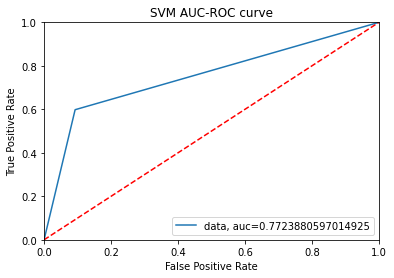

In [36]:
fpr, tpr, threshold = metrics.roc_curve(output_test_data, svm_pred)

plt.plot(fpr,tpr,label="data, auc="+str(svm_acc))
plt.title('SVM AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Tree classifiers

We will next try some tree classifiers (CART and Random Forest classifiers)

### Cart

In [37]:
from sklearn import tree, metrics

In [38]:
#training of the classifier
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=3)
clf = clf.fit(input_training_data, output_training_data)

cart_acc = clf.score(input_test_data,output_test_data)
print("CART accuracy : ",cart_acc)

CART accuracy :  0.7723880597014925


[Text(167.4, 190.26, 'Sex <= 0.5\ngini = 0.461\nsamples = 623\nvalue = [398, 225]\nclass = yes'),
 Text(83.7, 135.9, 'Fare <= 0.051\ngini = 0.277\nsamples = 409\nvalue = [341, 68]\nclass = yes'),
 Text(41.85, 81.53999999999999, 'Parch <= 0.083\ngini = 0.21\nsamples = 294\nvalue = [259, 35]\nclass = yes'),
 Text(20.925, 27.180000000000007, 'gini = 0.163\nsamples = 269\nvalue = [245, 24]\nclass = yes'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.493\nsamples = 25\nvalue = [14, 11]\nclass = yes'),
 Text(125.55000000000001, 81.53999999999999, 'Fare <= 0.052\ngini = 0.409\nsamples = 115\nvalue = [82, 33]\nclass = yes'),
 Text(104.625, 27.180000000000007, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = no'),
 Text(146.475, 27.180000000000007, 'gini = 0.392\nsamples = 112\nvalue = [82, 30]\nclass = yes'),
 Text(251.10000000000002, 135.9, 'Pclass <= 0.75\ngini = 0.391\nsamples = 214\nvalue = [57, 157]\nclass = no'),
 Text(209.25, 81.53999999999999, 'Embarked <= 0.875\ngini = 0.1

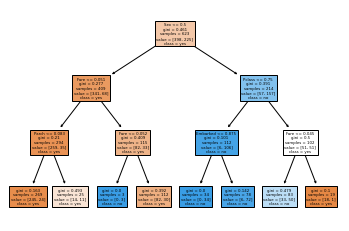

In [39]:
tree.plot_tree(clf,feature_names=features,class_names=["yes","no"],filled=True) 

In [40]:
# validation of the model with test set
cart_pred = clf.predict(input_test_data).reshape((-1,1))

In [41]:
# metrics of the model
cart_confusion_matrix = metrics.confusion_matrix(output_test_data,cart_pred)
kappa = metrics.cohen_kappa_score(output_test_data,cart_pred)
print("Matrice de confusion : \n",cart_confusion_matrix)
print("Kappa : ",kappa)

Matrice de confusion : 
 [[133  18]
 [ 43  74]]
Kappa :  0.5259250666975989


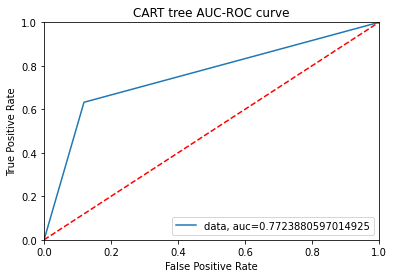

In [42]:
fpr, tpr, threshold = metrics.roc_curve(output_test_data, cart_pred)

plt.plot(fpr,tpr,label="data, auc="+str(cart_acc))
plt.title('CART tree AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, criterion='gini')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(input_training_data,output_training_data)

rdf_acc = clf.score(input_test_data,output_test_data)

print("Random forest accuracy : ",rdf_acc)

y_pred_rf=clf.predict(input_test_data)

Random forest accuracy :  0.7835820895522388


In [45]:
rdf_confusion_matrix = confusion_matrix(output_test_data,y_pred_rf)
print("Random forest confusion matrix : \n",rdf_confusion_matrix)

Random forest confusion matrix : 
 [[132  19]
 [ 39  78]]


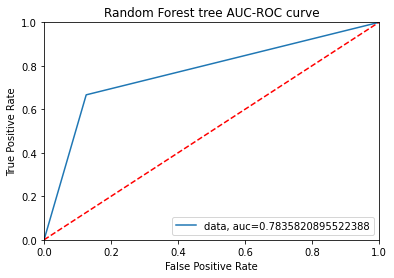

In [46]:
fpr, tpr, threshold = metrics.roc_curve(output_test_data, y_pred_rf)

plt.plot(fpr,tpr,label="data, auc="+str(rdf_acc))
plt.title('Random Forest tree AUC-ROC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Comparison of all classifiers

In [48]:
print("nn accuracy : ",np.round(nn_acc,2))
print("log accuracy : ",np.round(log_acc,2))
print("svm accuracy : ",np.round(svm_acc,2))
print("cart accuracy : ",np.round(cart_acc,2))
print("rdf accuracy : ",np.round(rdf_acc,2))

print("nn confusion matrix : \n",nn_confusion_matrix)
print("log confusion matrix : \n",log_confusion_matrix)
print("svm confusion matrix : \n",svm_confusion_matrix)
print("cart confusion matrix : \n",cart_confusion_matrix)
print("rdf confusion matrix : \n",rdf_confusion_matrix)

nn accuracy :  0.78
log accuracy :  0.78
svm accuracy :  0.77
cart accuracy :  0.77
rdf accuracy :  0.78
nn confusion matrix : 
 [[143   8]
 [ 50  67]]
log confusion matrix : 
 [[133  18]
 [ 42  75]]
svm confusion matrix : 
 [[137  14]
 [ 47  70]]
cart confusion matrix : 
 [[133  18]
 [ 43  74]]
rdf confusion matrix : 
 [[132  19]
 [ 39  78]]


## Conclusion 

Both methods, sequential neural network and logistic regression, gave impressivly high accuracy : 
- 78 % of accuracy for sequential neural network
- 79 % of accuracu for logistic regression
- 80 % for SVM
- 79 % for CART 
- 76 % for random forest

The approach above could be optimiserd or some other machine learning technics could be implemented in order to achieve a better score.